<a href="https://colab.research.google.com/github/ArushiG11/Advanced_Robotics/blob/main/AdvancedRobotics_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install mujoco
!pip install mujoco_py
!pip install gymnasium

In [36]:
import mujoco
import numpy as np
import os

# Load Mujoco XML file
MODEL_PATH = "/content/nav1.xml"
model = mujoco.MjModel.from_xml_path(MODEL_PATH)
data = mujoco.MjData(model)

# Set up viewer (optional, for debugging)
# viewer = mujoco.Viewer(model, data)

# Define initial sampling of states
def reset_simulation(data):

    data.qpos[:] = np.random.uniform(-0.5, 0.5, size=model.nq)
    data.qvel[:] = np.random.uniform(-0.1, 0.1, size=model.nv)
    mujoco.mj_forward(model, data)
    return np.concatenate([data.qpos, data.qvel])

reset_simulation(data)

array([-0.31015583,  0.34890579,  0.0651059 , -0.04651551])

In [37]:
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.mean = nn.Linear(64, output_dim)
        self.log_std = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        return mean, log_std.exp()

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [38]:
def get_state(data):
    x = data.qpos[0]
    y = data.qpos[1]
    x_dot = data.qvel[0]
    y_dot = data.qvel[1]
    return np.array([x, y, x_dot, y_dot], dtype=np.float32)

def calculate_reward(data, goal_position, epsilon=0.1):
    distance = np.linalg.norm(data.qpos[:2] - goal_position)
    return -distance if distance > epsilon else 10

goal_position = np.array([0.9, 0.0])

In [41]:
gamma = 0.99
lr_actor = 1e-4
lr_critic = 1e-3
episodes = 1000
max_steps = 200

actor = Actor(input_dim=4, output_dim=2)
critic = Critic(input_dim=4)
actor_optimizer = optim.Adam(actor.parameters(), lr=lr_actor)
critic_optimizer = optim.Adam(critic.parameters(), lr=lr_critic)
episode_rewards = []

for episode in range(episodes):
    state = reset_simulation(data)
    log_probs = []
    values = []
    rewards = []
    total_reward = 0

    for t in range(max_steps):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        mean, std = actor(state_tensor)
        action = torch.normal(mean, std)
        action_np = action.detach().numpy()

        # Apply to Mujoco
        data.ctrl[:] = action_np
        mujoco.mj_step(model, data)

        reward = calculate_reward(data, goal_position, epsilon=0.1)
        next_state = get_state(data)

        rewards.append(reward)
        values.append(critic(state_tensor))
        log_prob = torch.distributions.Normal(mean, std).log_prob(action).sum()
        log_probs.append(log_prob)

        total_reward += reward
        state = next_state

    returns = []
    g = 0
    for reward in reversed(rewards):
        g = reward + gamma * g
        returns.insert(0, g)

    returns = torch.FloatTensor(returns)
    values = torch.stack(values)
    log_probs = torch.stack(log_probs)

    advantage = returns - values.detach()

    actor_loss = -(log_probs * advantage).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    critic_loss = nn.MSELoss()(values, returns)
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    episode_rewards.append(total_reward)
    print(f"Episode {episode}, Total Reward: {total_reward}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 0, Total Reward: -169.51862921330076
Episode 1, Total Reward: -353.6495255672367
Episode 2, Total Reward: -398.5824741879176
Episode 3, Total Reward: -309.3104493644788
Episode 4, Total Reward: -356.61868643894707
Episode 5, Total Reward: -397.27724690060904
Episode 6, Total Reward: -260.29975929578745
Episode 7, Total Reward: -419.7190143077007
Episode 8, Total Reward: -280.5208126592187
Episode 9, Total Reward: -309.7366511408547
Episode 10, Total Reward: -364.86474085426914
Episode 11, Total Reward: -303.47473733988676
Episode 12, Total Reward: -299.29278003042924
Episode 13, Total Reward: -266.29826154661566
Episode 14, Total Reward: -269.52984751659255
Episode 15, Total Reward: -317.80898710560905
Episode 16, Total Reward: -345.87376196094414
Episode 17, Total Reward: -176.43522141263986
Episode 18, Total Reward: -218.20624012743784
Episode 19, Total Reward: -322.7012548060255
Episode 20, Total Reward: -232.01127361449278
Episode 21, Total Reward: -234.84004585666486
Episo

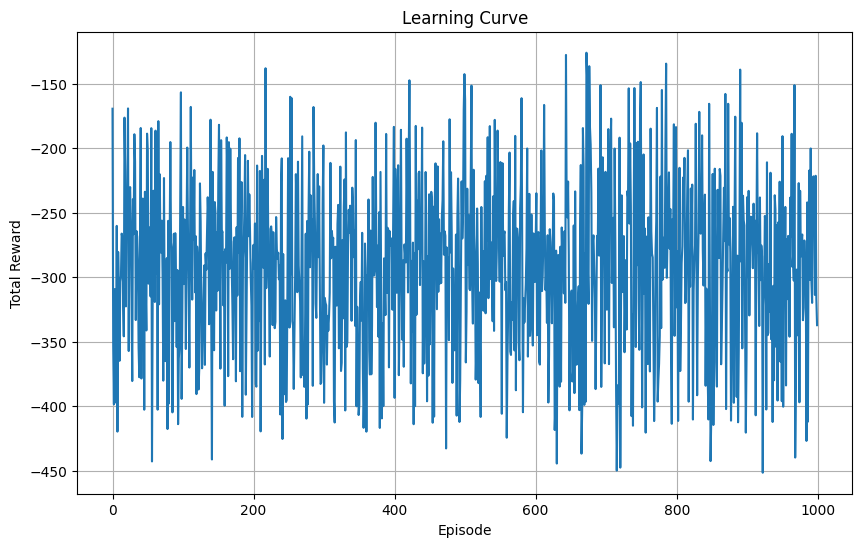

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.title('Learning Curve')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)